In [212]:
#Import libraries
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

In [213]:
kernel_x = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
kernel_y = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
Gaussian_filter = (1/273)*np.array([[ 1 , 4,  7,  4, 1 ],
       [ 4, 16, 26, 16,  4],
       [ 7, 26, 41 , 26,  7],
        [ 4, 16, 26, 16,  4],
        [ 1 , 4,  7,  4, 1 ]])
def convolution(Image, weights, stride=1):

    height, width = Image.shape
    kernel_height, kernel_width= weights.shape
    # Calculate the output dimensions
    out_height = (height - kernel_height) // stride + 1
    out_width = (width - kernel_width) // stride + 1

    # Initialize the output tensor
    output = np.zeros((out_height, out_width))

    # Perform the convolution
    for h in range(out_height):
        for w in range(out_width):
            h_start, w_start = h * stride, w * stride
            h_end, w_end = h_start + kernel_height, w_start + kernel_width
            X_slice = Image[h_start:h_end, w_start:w_end]
            # Apply convolution and add bias
            prod =  X_slice*(weights[:])
            sum1 = np.sum(prod, axis=None) 
            output[h, w] = sum1

    return np.array(output)


def get_images(image_dir, image_files):
    grayscale_images = []
    for image_file in image_files:
        # Construct the full path to the image file
        image_path = os.path.join(image_dir, image_file)
        # Read the image using OpenCV
        img = cv2.imread(image_path)
        # Convert BGR to RGB since OpenCV uses BGR by default
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Convert to grayscale using the formula I = 0.299R + 0.587G + 0.114B
        grayscale = 0.299 * img_rgb[:,:,0] + 0.587 * img_rgb[:,:,1] + 0.114 * img_rgb[:,:,2]
        grayscale = np.clip(grayscale, 0, 255).astype(np.uint8)
        #print(grayscale.shape)
        grayscale = cv2.resize(grayscale, (70,134), interpolation=cv2.INTER_AREA)
        grayscale_images.append(grayscale)
#         plt.imshow(grayscale, cmap='gray')  # Use cmap='gray' for grayscale images
#         plt.axis('off')  # Optional: Removes the axis ticks and labels
#         plt.show()
    return grayscale_images

# Convert the list of grayscale images to a NumPy array
# get positive 
def compute_gradients_and_angle(image):
    # Compute gradients using Prewitt operators
    gradient_x = convolution(image, kernel_x)
    gradient_y = convolution(image, kernel_y)
    
    # Normalize gradients
    #gradient_x = np.clip(gradient_x, 0, 255).astype(np.uint8)
    #gradient_y = np.clip(gradient_y, 0, 255).astype(np.uint8)
    
    # Compute gradient magnitude and angle
    magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    angle = np.arctan2(gradient_y, gradient_x) * (180 / np.pi)  # Convert to degrees
    angle = angle % 180
    # Normalize magnitude
    magnitude = np.clip(magnitude, 0, 255).astype(np.uint8)
    
    return gradient_x, gradient_y, magnitude, angle

def apply_prewitt_operator(images):
    prewitt_results = []
    for image in images:
        gradient_x, gradient_y, magnitude, angle = compute_gradients_and_angle(image)
        prewitt_results.append((gradient_x, gradient_y, magnitude, angle))
    return prewitt_results


# compute cell histograms 


def compute_cell_histograms(prewitt_results, cell_size=(8, 8), num_bins=9):    
    cells_histogram_array=[]
    for item in prewitt_results:
        gradx, grady, magnitude, angle = item
        cell_histograms = np.zeros((magnitude.shape[0] // cell_size[0], magnitude.shape[1]//cell_size[1],num_bins))
        #print(cell_histograms.shape)
        # Bin edges for histogram
        bin_edges = np.linspace(0, 180, num_bins+1, endpoint=True)
        for i in range(0, magnitude.shape[0], cell_size[0]):
            for j in range(0, magnitude.shape[1], cell_size[1]):
                cell_magnitude = magnitude[i:i+cell_size[0], j:j+cell_size[1]]
                cell_angle = angle[i:i+cell_size[0], j:j+cell_size[1]]

                bin_indices = np.digitize(cell_angle, bin_edges, right=False) - 1  # -1 to convert to 0-based indexing
                # Accumulate the histogram
                for k in range(cell_size[0]):
                    for l in range(cell_size[1]):
                        bin_index = bin_indices[k, l]
    #                         print(i // cell_size[0])
    #                         print(j // cell_size[1])
                        if bin_index >= 0 and bin_index < num_bins:  # Check bin index validity
                            cell_histograms[i // cell_size[0], j // cell_size[1], bin_index] += cell_magnitude[k, l]
        
        cells_histogram_array.append(cell_histograms)
    cells_histogram_array_np = np.array(cells_histogram_array)
    #print(cells_histogram_array_np.shape)
    return cells_histogram_array_np


def normalize_histograms(histograms, eps=1e-5):
    # Normalize using L2-norm
    norm = np.sqrt(np.sum(histograms ** 2) + eps ** 2)
    normalized_histogram = histograms / norm
    return normalized_histogram



def compute_blocks(cell_histograms, block_size=(2, 2), cell_size=(8, 8), num_bins=9):
    num_images, num_cells_y, num_cells_x, _ = cell_histograms.shape
    stride = 1  
    block_descriptors = []

    for img_index in range(num_images):
        blocks = []
        # Determine the range for iterating over cells
        for y in range(num_cells_y - block_size[1] + 1):
            for x in range(num_cells_x - block_size[0] + 1):
                # Extract the block
                block_histogram = cell_histograms[img_index, y:y+block_size[1], x:x+block_size[0], :].flatten()
                # Normalize the block histogram
                normalized_block_histogram = normalize_histograms(block_histogram)
                #print(normalized_block_histogram.shape)
                blocks.append(normalized_block_histogram)
        
        # Concatenate all block histograms to form the HOG descriptor for this image
        hog_descriptor = np.concatenate(blocks)
        block_descriptors.append(hog_descriptor)
    return np.array(block_descriptors)


def extract_HOG_features(train_path):
    image_dir = train_path
    #"./Downloads/data/Train_Negative"
    image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
    train= get_images(image_dir, image_files)
    train= np.array(train)
    Gaussian=[]
    for item in train:
        Gaussian.append(convolution(item, Gaussian_filter, 1))
    # Apply to positive and negative Gaussian filtered images
    prewitt_results = apply_prewitt_operator(Gaussian)
    cell_histogram = compute_cell_histograms(prewitt_results)
    block_descriptors = compute_blocks(cell_histogram, block_size=(2, 2), cell_size=(8, 8), num_bins=9)
    features = block_descriptors.T
    print(features.shape)
    return (block_descriptors, train_path)


#negative_prewitt_results = apply_prewitt_operator(negative_Gaussian)
# for item in positive_prewitt_results:
#     grad_x, grad_y, mag, ang = item 
#     plt.imshow(mag, cmap='gray')
#     plt.show()
#     plt.imshow(ang, cmap='gray')
#     plt.show()





In [214]:
# returns the sigmoid value for each value in Z
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

# returns the RELU activation for each value of net input Z
def RELU(Z):
    relu = Z.copy()
    relu[Z<0] = 0
    return relu

# returns the first order derivative of sigmoid at each value in z
def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

# returns the first order derivative of RELU at each value in z
def RELU_prime(Z):
    gradient = Z.copy()
    gradient[Z>0] = 1
    gradient[Z<=0] = 0
    return gradient

# returns the mean square error for predicted values 'a'
def mean_square_error(a,y):
    return 1/2 * (np.sum(np.square(y-a))/y.shape[1])

In [215]:
class NeuralNetwork:
    def __init__(self,counts):
        # counts: has count of no of neurons in each layer
        self.no_of_layers = len(counts)
        self.neurons_per_layer = counts
        self.weights=[]
        self.bias = []
        self.activations = []
        # intialising the weights, random initialisation of weights and bias
        for n in range(0,self.no_of_layers-1):
            epsilon = np.sqrt(6)/(np.sqrt(self.neurons_per_layer[n]+self.neurons_per_layer[n+1]))
            self.weights.append((np.random.rand(self.neurons_per_layer[n],self.neurons_per_layer[n+1]))*2*epsilon - epsilon)
            self.bias.append((np.random.rand(self.neurons_per_layer[n+1],1))*2*epsilon - epsilon)

    # feed forward the network, stores the net inputs and activations of each layer while feed forwarding
    def feed_forward(self,x_in):
        self.activations = [x_in]
        net_inputs = [x_in]
        layer = 1
        for w,b in zip(self.weights,self.bias):
            layer += 1
            # calculates the net input to each neuron in the layer - 'layer'
            z = np.transpose(w)@self.activations[-1] + b
            net_inputs.append(z)
            # applying sigmoid for output layer
            if(layer == self.no_of_layers):
                a = sigmoid(z)
            else:
                # Using RELU for hidden layers 
                a = RELU(z)
            self.activations.append(a) ################# probably needs indentation # DONE
        # returns net_inputs and activations of all the layers except input layer
        return (net_inputs,self.activations) ######## might be self.activations[1:]

    # this method is same as feed_forward except that this wont store net inputs and activations of hidden layers
    def feed_forward_classify(self,x_in):
        self.activations =x_in
        layer =1
        for w,b in zip(self.weights,self.bias):
            layer+=1
            z = np.transpose(w)@self.activations + b
            if(layer == self.no_of_layers):
                self.activations = sigmoid(z)
            else:
                self.activations = RELU(z)
        return self.activations ################# activations is not a variable change to self.activations

    # Back propogation to determine the sensitivities of neurons in each layer
    # sensitivity is nothing but change in ouput error per unit change in net input
    def back_prop(self,net_inputs,observed_out,target_out):
        sensitivities = []
        # s_last : sensitivity of neurons in last layer
        err_last = (observed_out - target_out)
        s_last = err_last * (sigmoid_prime(net_inputs[-1]))
        sensitivities.append(s_last)
        for i in range(self.no_of_layers-2, 0, -1):
            # determines sensitivities of neurons in hidden layers
            s = (self.weights[i]@sensitivities[0]) * RELU_prime(net_inputs[i])
            sensitivities.insert(0,s)
        return sensitivities, err_last

    # x_in - batch of input patterns
    # train_NN update the weights and bias using steepest descent approach
    def train_NN(self, x_in, target_out, lr):
        batch_size = x_in.shape[1]
        (net_inputs,self.activations) = self.feed_forward(x_in)
        sensitivities, err_last = self.back_prop(net_inputs,self.activations[-1],target_out)
        for l in range(0,self.no_of_layers-1):
            # updating weights and biases
            self.weights[l] = self.weights[l] -  ((lr/batch_size) * (self.activations[l]@np.transpose(sensitivities[l])))
            self.bias[l] = self.bias[l] - ((lr/batch_size) * (np.sum(sensitivities[l],axis = 1)[:,np.newaxis]))
        return sensitivities, err_last

    # SGD : stochastic gradient descent
    def SGD(self,input_patterns,target_out,lr,epochs,batch_size,tv_x=None,tv_y=None):
        no_of_patterns = input_patterns.shape[1]
        positions = np.arange(no_of_patterns)
        training_cost = []
        tv_cost=[]
        train_accuracy = []
        tv_accuracy = [] 
        for e in range(1,epochs+1):
#             print("epoch no:", e)
            np.random.shuffle(positions)
            # picking the batch(patterns) in random order given by positions(array of random values)
            for i in range(0,no_of_patterns,batch_size):
                sensitivities, err_last = self.train_NN(input_patterns[:,positions[i:i+batch_size]],target_out[:,positions[i:i+batch_size]],lr)
            # print (err_last)
        return 0

    # calculates accuracy by comparing the predicted and actual labels
    def accuracy(self,predicted,ts_y):
        y = predicted.copy()
        y[y>=0.5]=1
        y[y<0.5]=0
        total_patterns = y.shape[1]
        count=0
        print("This is the acc y:", y)
        print("ts_y", ts_y)
        for i in range(0,total_patterns):
            if(np.array_equal(y[:,i],ts_y[:,i])):
                count+=1
        accuracy = (count/total_patterns) * 100
        return y,accuracy

def train_test_network(train_X,train_Y,test_X,test_Y, no_of_neurons_in_hidden_layer = 250, epochs = 100):
    # Network Architecture - only one hidden layer
    no_of_features = train_X.shape[0]
    print("number of features", no_of_features)
    # no_of_neurons_in_hidden_layer = num_neurons
    no_of_neurons_in_output_layer = 1
    lr = 0.009
    batch_size = 1
    NN = NeuralNetwork([no_of_features, no_of_neurons_in_hidden_layer, no_of_neurons_in_output_layer])
    print("Training Neural Network for ",epochs," epochs")
    # training the network with train data the above mentioned hyper parameters
    NN.SGD(train_X, train_Y, lr, epochs, batch_size, tv_x = test_X, tv_y = test_Y)
    activations_test = NN.feed_forward_classify(test_X)
    # calculating the test set classification accuracy
    class_labels,accuracy = NN.accuracy(activations_test,test_Y)
    return activations_test,class_labels,accuracy

def print_results(sigmoid_out,class_labels,accuracy_test):
    test_all_path = './Downloads/data/Test_all/'
    test_image_names = os.listdir(test_all_path)

    print("Test Image",' '*15	,"Output Value", '  Classification' )
    for i in range(0,len(test_image_names)):
        l = len(test_image_names[i])
        img = plt.imread(test_all_path + test_image_names[i])
        plt.figure(i)
        plt.title(test_image_names[i])
        plt.imshow(img, vmin=0, vmax=255)
        # classifying the image as Human if the class label is 1, Not-human otherwise
        if(class_labels[0,i] == 1):
            class_str = 'Human'
        else:
            class_str = 'Not-Human'
        print(test_image_names[i],' '*(30-l),sigmoid_out[0,i], '      ', class_str)

    print()
    print("test set classification accuracy:", accuracy_test)

In [218]:
# Train the neural network
# path of image sets - train, test
pos_train_path = './Downloads/data/Train_Positive/'
neg_train_path = './Downloads/data/Train_Negative/'
pos_test_path = './Downloads/data/Test_Positive/'
neg_test_path = './Downloads/data/Test_Negative/'

print("Extracting Features ... ", end = "")
train_X_pos, image_names_pos_train = extract_HOG_features(pos_train_path)
train_X_neg, image_names_neg_train = extract_HOG_features(neg_train_path)
test_X_pos, image_names_pos_test = extract_HOG_features(pos_test_path)
test_X_neg, image_names_neg_test = extract_HOG_features(neg_test_path)
print("Done")

print("train_X_pos and train_x_neg shape: ", train_X_pos.shape)
train_X = np.vstack([train_X_pos, train_X_neg]).T
train_Y = np.hstack([np.full((1,train_X_pos.shape[0]),1), np.full((1,train_X_neg.shape[0]),0)])
print("train_X: {}, train_Y: {}".format(train_X.shape, train_Y.shape))

print("test_X_pos and test_x_neg shape: ", test_X_pos.shape)
test_X = np.vstack([test_X_neg[:3],test_X_pos, test_X_neg[3:]]).T
test_Y = np.hstack([np.full((1,3),0), np.full((1,test_X_neg.shape[0]),1), np.full((1,2), 0)])
print("test_X: {}, test_Y: {}".format(test_X.shape, test_Y))
# print("Training... ")
sig_list = []
class_list = []
acc_list = []
hid_lyr = [250, 500, 1000]
# hid_lyr = [200]
for i in hid_lyr:
    so, cl, at = train_test_network(train_X, train_Y, test_X, test_Y, i)
    so = np.round(so, decimals=3)
    sig_list.append(so)
    class_list.append(cl)
    acc_list.append(at)
    print("accuracy: ",at)
    

print("Done")


Extracting Features ... (3780, 10)
(3780, 10)
(3780, 5)
(3780, 5)
Done
train_X_pos and train_x_neg shape:  (10, 3780)
train_X: (3780, 20), train_Y: (1, 20)
test_X_pos and test_x_neg shape:  (5, 3780)
test_X: (3780, 10), test_Y: [[0 0 0 1 1 1 1 1 0 0]]
number of features 3780
Training Neural Network for  100  epochs
This is the acc y: [[0. 0. 0. 1. 1. 1. 1. 1. 0. 0.]]
ts_y [[0 0 0 1 1 1 1 1 0 0]]
accuracy:  100.0
number of features 3780
Training Neural Network for  100  epochs
This is the acc y: [[0. 0. 0. 1. 1. 1. 1. 1. 0. 0.]]
ts_y [[0 0 0 1 1 1 1 1 0 0]]
accuracy:  100.0
number of features 3780
Training Neural Network for  100  epochs
This is the acc y: [[0. 0. 0. 1. 1. 1. 1. 1. 0. 0.]]
ts_y [[0 0 0 1 1 1 1 1 0 0]]
accuracy:  100.0
Done


Test Image                 Output Value   Classification
no_person__no_bike_247_cut.bmp  0.254        Not-Human
00000093a_cut.bmp               0.167        Not-Human
crop_000010b.bmp                0.384        Not-Human
crop001028a.bmp                 0.791        Human
crop001008b.bmp                 0.893        Human
crop001045b.bmp                 0.87        Human
crop001047b.bmp                 0.691        Human
00000062a_cut.bmp               0.615        Human
00000053a_cut.bmp               0.254        Not-Human
no_person__no_bike_213_cut.bmp  0.467        Not-Human

test set classification accuracy: 100.0
Test Image                 Output Value   Classification
no_person__no_bike_247_cut.bmp  0.293        Not-Human
00000093a_cut.bmp               0.185        Not-Human
crop_000010b.bmp                0.521        Human
crop001028a.bmp                 0.814        Human
crop001008b.bmp                 0.919        Human
crop001045b.bmp                 0.907        Human
cr

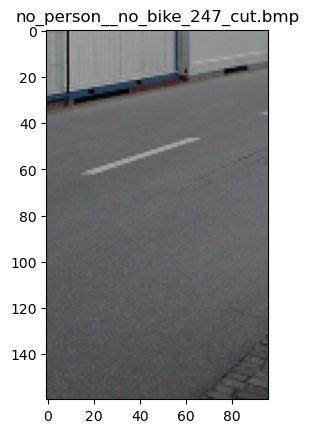

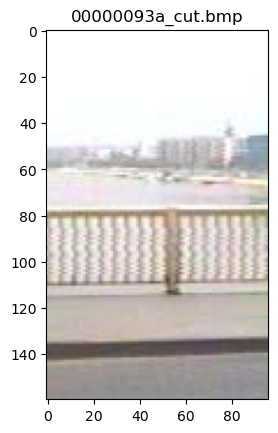

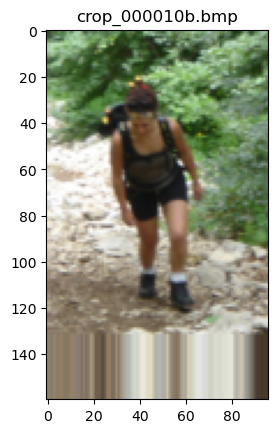

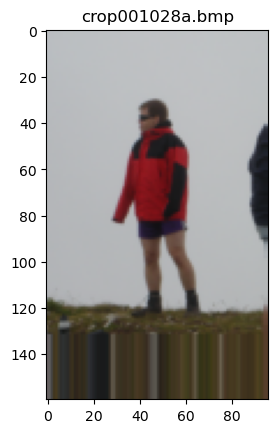

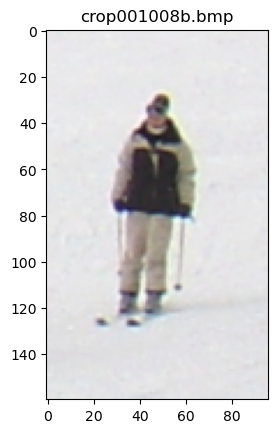

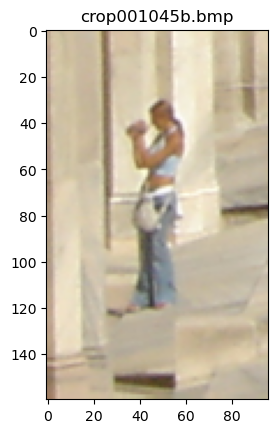

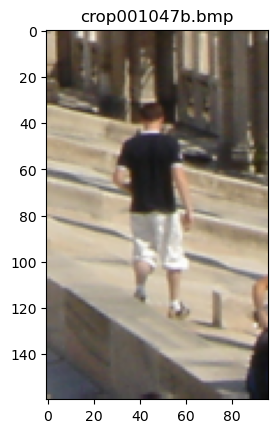

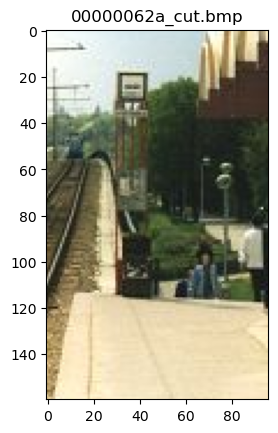

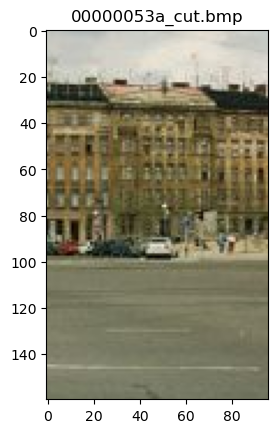

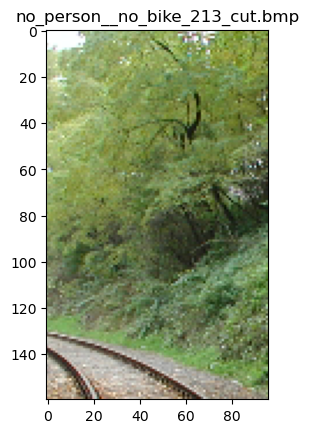

In [216]:
for i in range(len(sig_list)):
    print_results(sig_list[i], class_list[i], acc_list[i])

In [217]:
# Testing with other layer 

pos_train_path = './Downloads/data/Train_Positive/'
neg_train_path = './Downloads/data/Train_Negative/'
pos_test_path = './Downloads/data/Test_Positive/'
neg_test_path = './Downloads/data/Test_Negative/'

print("Extracting Features ... ", end = "")
train_X_pos, image_names_pos_train = extract_HOG_features(pos_train_path)
train_X_neg, image_names_neg_train = extract_HOG_features(neg_train_path)
test_X_pos, image_names_pos_test = extract_HOG_features(pos_test_path)
test_X_neg, image_names_neg_test = extract_HOG_features(neg_test_path)
print("Done")

print("train_X_pos and train_x_neg shape: ", train_X_pos.shape)
train_X = np.vstack([train_X_pos, train_X_neg]).T
train_Y = np.hstack([np.full((1,train_X_pos.shape[0]),1), np.full((1,train_X_neg.shape[0]),0)])
print("train_X: {}, train_Y: {}".format(train_X.shape, train_Y.shape))

print("test_X_pos and test_x_neg shape: ", test_X_pos.shape)
test_X = np.vstack([test_X_neg[:3],test_X_pos, test_X_neg[3:]]).T
test_Y = np.hstack([np.full((1,3),0), np.full((1,test_X_neg.shape[0]),1), np.full((1,2), 0)])
print("test_X: {}, test_Y: {}".format(test_X.shape, test_Y))
# print("Training... ")
sig_list = []
class_list = []
acc_list = []
hid_lyr = [300, 600, 1000]
# hid_lyr = [200]
for i in hid_lyr:
    so, cl, at = train_test_network(train_X, train_Y, test_X, test_Y, i)
    so = np.round(so, decimals=3)
    sig_list.append(so)
    class_list.append(cl)
    acc_list.append(at)
    print("accuracy: ",at)
    

print("Done")



Extracting Features ... (3780, 10)
(3780, 10)
(3780, 5)
(3780, 5)
Done
train_X_pos and train_x_neg shape:  (10, 3780)
train_X: (3780, 20), train_Y: (1, 20)
test_X_pos and test_x_neg shape:  (5, 3780)
test_X: (3780, 10), test_Y: [[0 0 0 1 1 1 1 1 0 0]]
number of features 3780
Training Neural Network for  100  epochs
This is the acc y: [[0. 0. 0. 1. 1. 1. 1. 1. 0. 0.]]
ts_y [[0 0 0 1 1 1 1 1 0 0]]
accuracy:  100.0
number of features 3780
Training Neural Network for  100  epochs
This is the acc y: [[0. 0. 0. 1. 1. 1. 1. 1. 0. 0.]]
ts_y [[0 0 0 1 1 1 1 1 0 0]]
accuracy:  100.0
number of features 3780
Training Neural Network for  100  epochs
This is the acc y: [[0. 0. 0. 1. 1. 1. 1. 1. 0. 0.]]
ts_y [[0 0 0 1 1 1 1 1 0 0]]
accuracy:  100.0
Done


Test Image                 Output Value   Classification
no_person__no_bike_247_cut.bmp  0.28        Not-Human
00000093a_cut.bmp               0.169        Not-Human
crop_000010b.bmp                0.466        Not-Human
crop001028a.bmp                 0.798        Human
crop001008b.bmp                 0.929        Human
crop001045b.bmp                 0.889        Human
crop001047b.bmp                 0.715        Human
00000062a_cut.bmp               0.607        Human
00000053a_cut.bmp               0.305        Not-Human
no_person__no_bike_213_cut.bmp  0.448        Not-Human

test set classification accuracy: 100.0
Test Image                 Output Value   Classification
no_person__no_bike_247_cut.bmp  0.35        Not-Human
00000093a_cut.bmp               0.131        Not-Human
crop_000010b.bmp                0.465        Not-Human
crop001028a.bmp                 0.638        Human
crop001008b.bmp                 0.837        Human
crop001045b.bmp                 0.832        Human

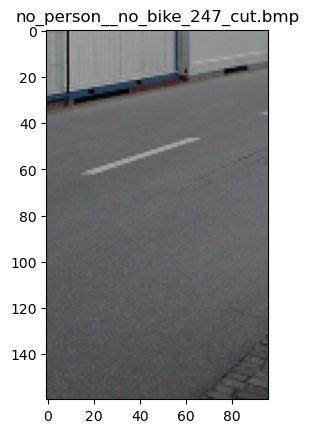

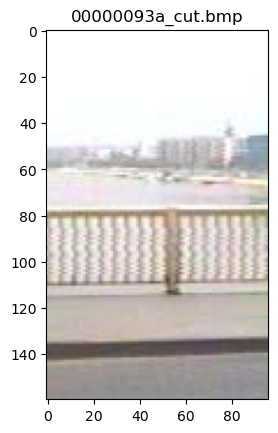

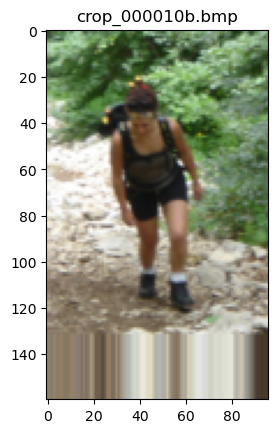

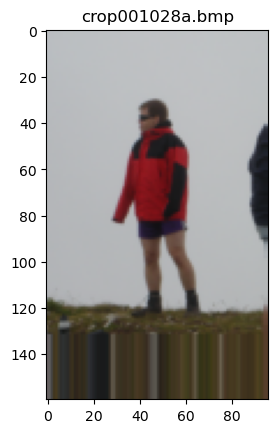

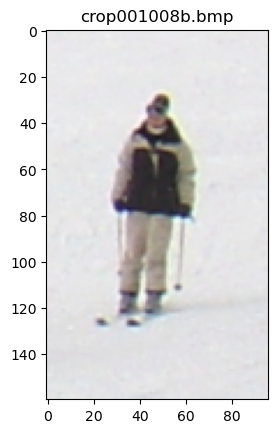

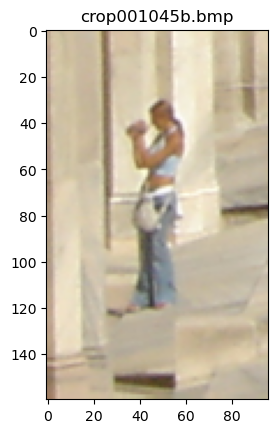

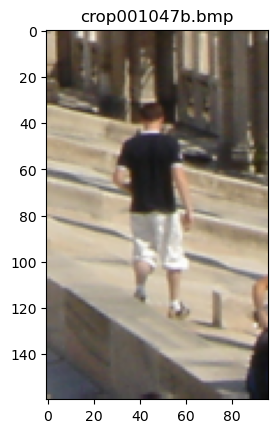

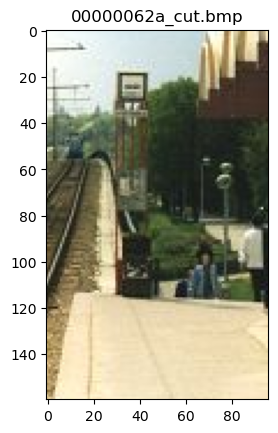

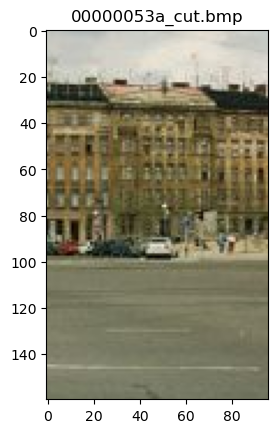

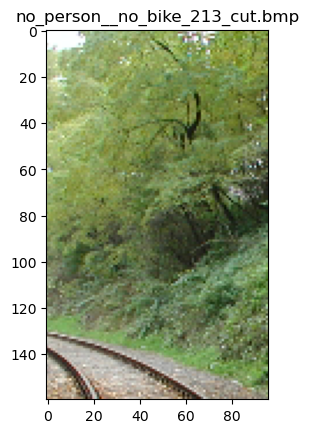

In [197]:
for i in range(len(sig_list)):
    print_results(sig_list[i], class_list[i], acc_list[i])